In [1]:
# Imports we will use
import torch
import gc
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import random
from pathlib import Path
from sklearn.metrics import r2_score
from astropy.visualization import make_lupton_rgb
from sklearn.manifold import Isomap
from train_utils import *
import time
import os
import json

%matplotlib inline
plt.rcParams.update({'font.size': 12})

# Set Seed
torch.manual_seed(11)

# Find if cuda is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Load Data

In [2]:
# Specify paths, load in data, and subsample labels
head = Path.cwd().parents[1]
source_img_path = head / 'data/mb_lenscolor_source/mb_lenscolor_source.npy'
target_img_path = head / 'data/mb_lenscolor_target/mb_lenscolor_target.npy'
source_meta = head / 'data/mb_lenscolor_source/mb_lenscolor_source_metadata.csv'
target_meta = head / 'data/mb_lenscolor_target/mb_lenscolor_target_metadata.csv'
batch_size = 64
source_train_dataloader, source_test_dataloader, source_val_dataloader, source_data = create_dataloader(source_img_path, source_meta, batch_size)
target_train_dataloader, target_test_dataloader, target_val_dataloader, target_data = create_dataloader(target_img_path, target_meta, batch_size)
isomap_source_label_sample = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
isomap_target_label_sample = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

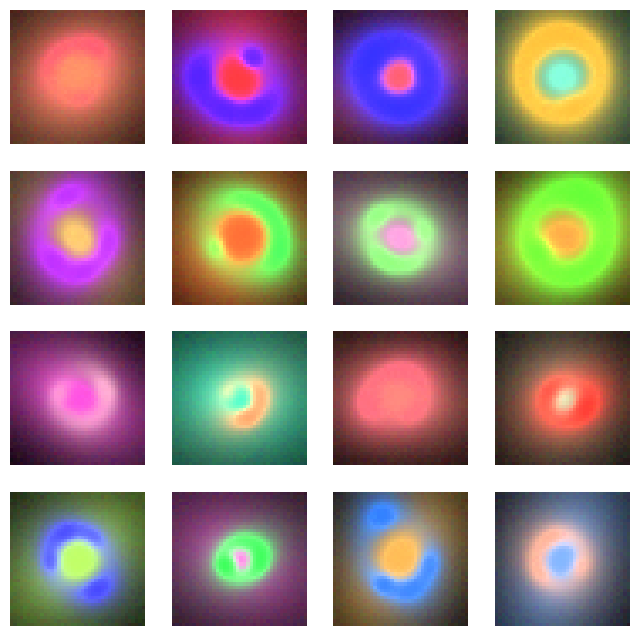

In [3]:
# Visualize source data
visualize_data(source_data)

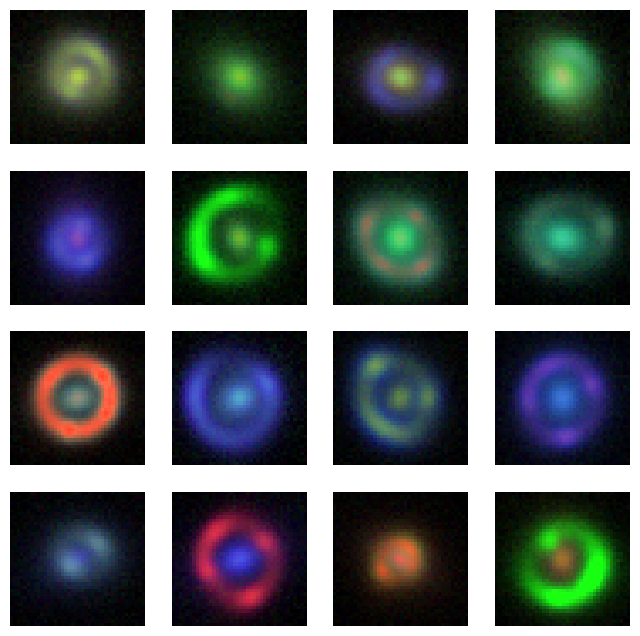

In [4]:
# Visualize target data
visualize_data(target_data)

## Model Setup

In [5]:
# Choose how you prefer to evolve beta and the DA Weight
def da_weight_function(epoch):
    """ Linear evolving DA weighting in loss function. """
    da_weight = init_wt_da - ((init_wt_da - final_wt_da) * (epoch / n_epoch))
    return 0

def beta_function(epoch):
    """ Linear evolving beta weighting in loss function until halfway through total epochs. """
    beta_val = beta_init - (beta_init - beta_final) * (epoch / n_epoch)
    return beta_val

# Initialize hyperparameters
learning_rate = 1e-5
n_epoch = 125
extra_epoch = n_epoch
init_wt_da = 1.4
final_wt_da = 1.0
beta_init = 1.0
beta_final = 0.0

In [6]:
# Initialize model
model = NeuralNetworkMVE(npix=40).cuda()

# Loss Functions / Optimizers
regressor_loss_fn = nn.MSELoss().cuda()
da_loss_fn = MMD_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
# To continue training from a past model, enter path into load_mod_name
# Else, enter None, and you still have to run the function.
# Then, enter save_mod_name to save for the current run  

load_mod_name = None # "models/mve_noDA_v1_aug7_0100_final" #"models/mve_noDA_v1_aug7_0100" # "models/start_code_test_2"
stats, model, optimizer, best_target_R2, best_mve_loss = initialize_state(load_mod_name, model, optimizer)


#save_mod_name = load_mod_name # may overwrite loaded model
save_mod_name = "models/mve_noDA_v4_aug7_1950"

## Train

Beginning Training...
Generating Isomap...


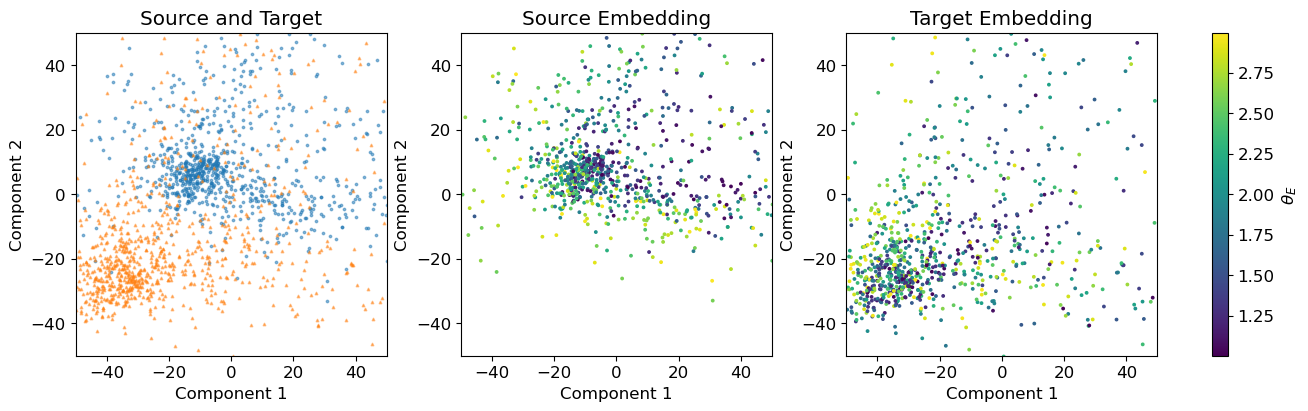


Epoch 0: 11.09s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2360
	Train Regression Loss: : 1.9518
	Train Mve Loss: : 0.8569
	Train R2 Score: : -5.0116
 Validation Statistics:
	Val Source Regression Loss: : 0.8157
	Val Target Regression Loss: : 0.8048
	Val Source R2 Score: : -1.4949
	Val Target R2 Score: : -1.4761
	Val Source Mve Loss: : 0.3244
	Val Target Mve Loss: : 0.3243
Saving Model MVE... Done.

Epoch 1: 10.31s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2155
	Train Regression Loss: : 0.4861
	Train Mve Loss: : 0.1171
	Train R2 Score: : -0.4848
 Validation Statistics:
	Val Source Regression Loss: : 0.3541
	Val Target Regression Loss: : 0.3794
	Val Source R2 Score: : -0.0711
	Val Target R2 Score: : -0.1619
	Val Source Mve Loss: : 0.0076
	Val Target Mve Loss: : 0.0231
Saving Model... Done.
Saving Model MVE... Done.

Epoch 2: 11.30s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2213
	Train Regress

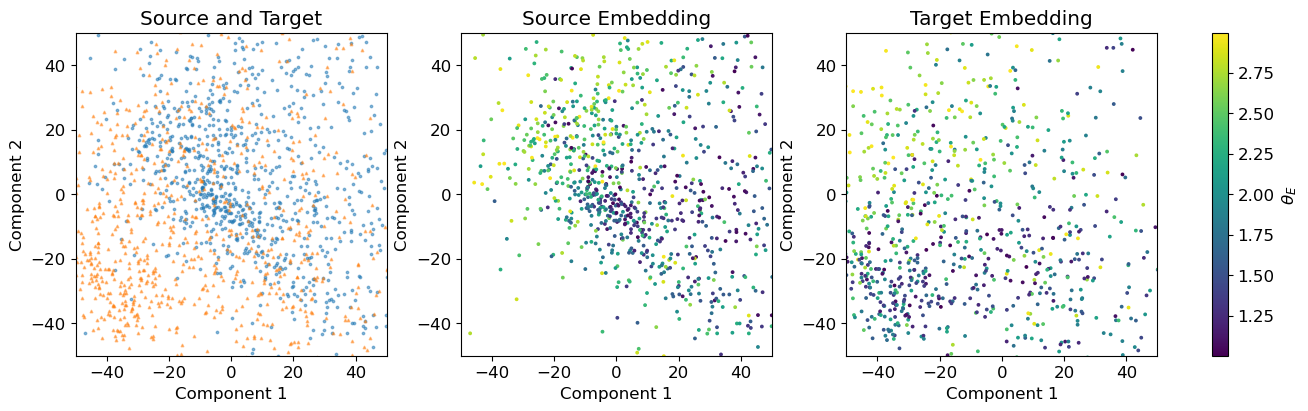


Epoch 20: 10.88s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2623
	Train Regression Loss: : 0.0386
	Train Mve Loss: : -0.1164
	Train R2 Score: : 0.8819
 Validation Statistics:
	Val Source Regression Loss: : 0.0395
	Val Target Regression Loss: : 0.0667
	Val Source R2 Score: : 0.8791
	Val Target R2 Score: : 0.7940
	Val Source Mve Loss: : -0.1115
	Val Target Mve Loss: : -0.1037

Epoch 21: 10.42s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2628
	Train Regression Loss: : 0.0381
	Train Mve Loss: : -0.1301
	Train R2 Score: : 0.8839
 Validation Statistics:
	Val Source Regression Loss: : 0.0397
	Val Target Regression Loss: : 0.0664
	Val Source R2 Score: : 0.8797
	Val Target R2 Score: : 0.7956
	Val Source Mve Loss: : -0.1869
	Val Target Mve Loss: : -0.1714
Saving Model... Done.
Saving Model MVE... Done.

Epoch 22: 10.48s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2580
	Train Regression Loss: : 0.0380
	Tra

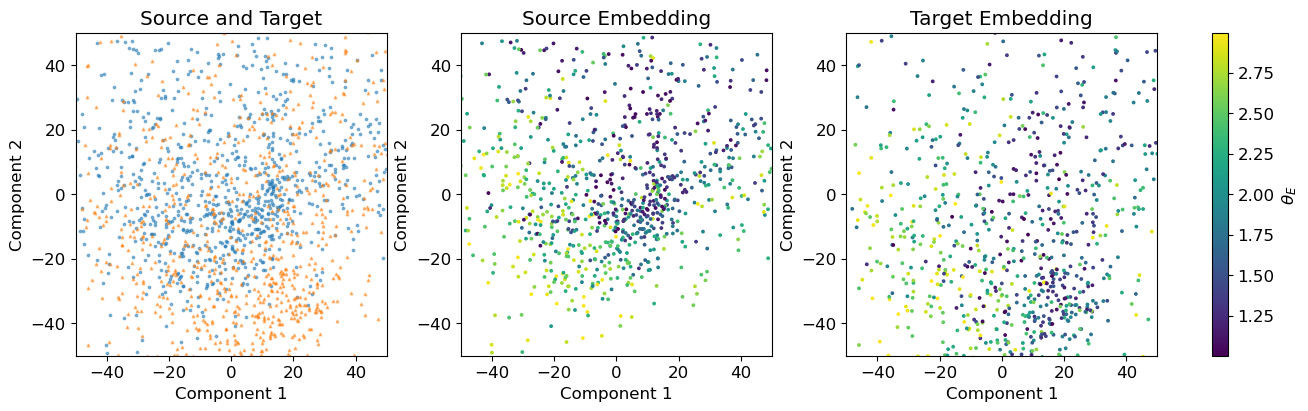

Saving Model MVE... Done.

Epoch 40: 10.10s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2679
	Train Regression Loss: : 0.0295
	Train Mve Loss: : -0.2014
	Train R2 Score: : 0.9099
 Validation Statistics:
	Val Source Regression Loss: : 0.0307
	Val Target Regression Loss: : 0.0649
	Val Source R2 Score: : 0.9064
	Val Target R2 Score: : 0.8015
	Val Source Mve Loss: : -0.0938
	Val Target Mve Loss: : -0.0014
Saving Model... Done.

Epoch 41: 9.96s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2687
	Train Regression Loss: : 0.0293
	Train Mve Loss: : -0.1496
	Train R2 Score: : 0.9105
 Validation Statistics:
	Val Source Regression Loss: : 0.0302
	Val Target Regression Loss: : 0.0652
	Val Source R2 Score: : 0.9077
	Val Target R2 Score: : 0.7981
	Val Source Mve Loss: : -0.1320
	Val Target Mve Loss: : -0.0593

Epoch 42: 10.35s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2710
	Train Regression Loss: : 0.0290
	Trai

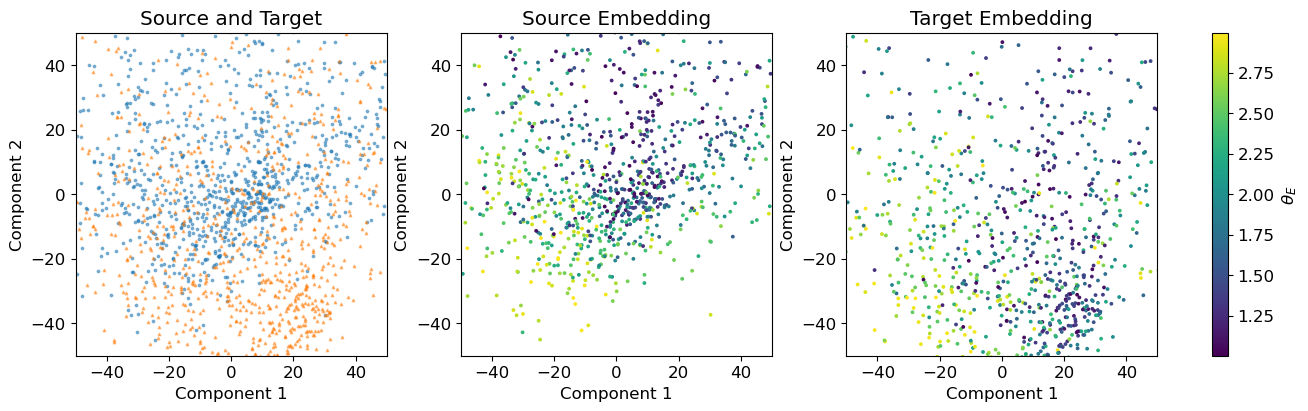


Epoch 60: 10.27s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2752
	Train Regression Loss: : 0.0256
	Train Mve Loss: : -0.3008
	Train R2 Score: : 0.9219
 Validation Statistics:
	Val Source Regression Loss: : 0.0270
	Val Target Regression Loss: : 0.0749
	Val Source R2 Score: : 0.9133
	Val Target R2 Score: : 0.7676
	Val Source Mve Loss: : -0.2871
	Val Target Mve Loss: : -0.2548
Saving Model MVE... Done.

Epoch 61: 10.59s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2747
	Train Regression Loss: : 0.0254
	Train Mve Loss: : -0.1396
	Train R2 Score: : 0.9224
 Validation Statistics:
	Val Source Regression Loss: : 0.0262
	Val Target Regression Loss: : 0.0744
	Val Source R2 Score: : 0.9197
	Val Target R2 Score: : 0.7693
	Val Source Mve Loss: : 0.2716
	Val Target Mve Loss: : 1.1581

Epoch 62: 10.40s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2749
	Train Regression Loss: : 0.0251
	Train Mve Loss: : -0.1183
	

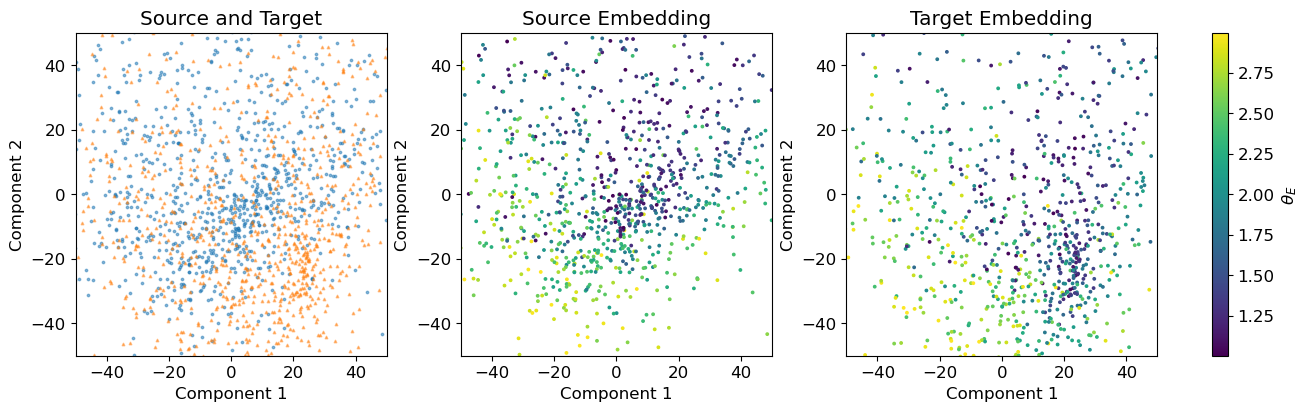

Saving Model MVE... Done.

Epoch 80: 10.65s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2390
	Train Regression Loss: : 0.0241
	Train Mve Loss: : 0.4761
	Train R2 Score: : 0.9261
 Validation Statistics:
	Val Source Regression Loss: : 0.0247
	Val Target Regression Loss: : 0.0564
	Val Source R2 Score: : 0.9255
	Val Target R2 Score: : 0.8252
	Val Source Mve Loss: : 3.7850
	Val Target Mve Loss: : 5.9638

Epoch 81: 10.84s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2371
	Train Regression Loss: : 0.0236
	Train Mve Loss: : 0.4499
	Train R2 Score: : 0.9274
 Validation Statistics:
	Val Source Regression Loss: : 0.0249
	Val Target Regression Loss: : 0.0585
	Val Source R2 Score: : 0.9239
	Val Target R2 Score: : 0.8186
	Val Source Mve Loss: : 0.4040
	Val Target Mve Loss: : 0.6009

Epoch 82: 10.50s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2370
	Train Regression Loss: : 0.0233
	Train Mve Loss: : 0.9326
	Train

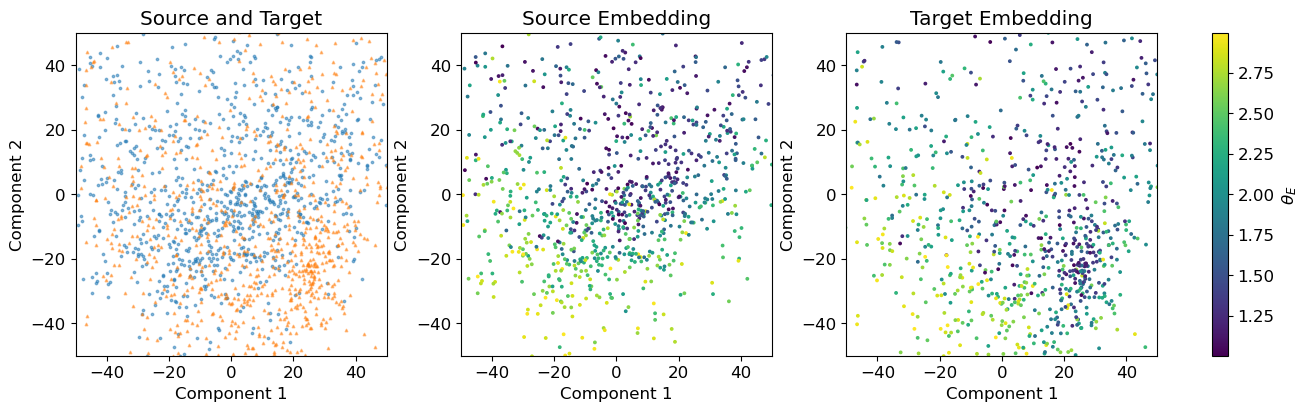

Saving Model MVE... Done.

Epoch 100: 10.60s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2397
	Train Regression Loss: : 0.0222
	Train Mve Loss: : -0.3938
	Train R2 Score: : 0.9321
 Validation Statistics:
	Val Source Regression Loss: : 0.0224
	Val Target Regression Loss: : 0.0643
	Val Source R2 Score: : 0.9314
	Val Target R2 Score: : 0.7990
	Val Source Mve Loss: : -0.6015
	Val Target Mve Loss: : 0.0806

Epoch 101: 10.66s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2390
	Train Regression Loss: : 0.0218
	Train Mve Loss: : 0.3566
	Train R2 Score: : 0.9335
 Validation Statistics:
	Val Source Regression Loss: : 0.0223
	Val Target Regression Loss: : 0.0662
	Val Source R2 Score: : 0.9317
	Val Target R2 Score: : 0.7956
	Val Source Mve Loss: : 1.2522
	Val Target Mve Loss: : 24.9192

Epoch 102: 10.22s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2372
	Train Regression Loss: : 0.0215
	Train Mve Loss: : 0.4453


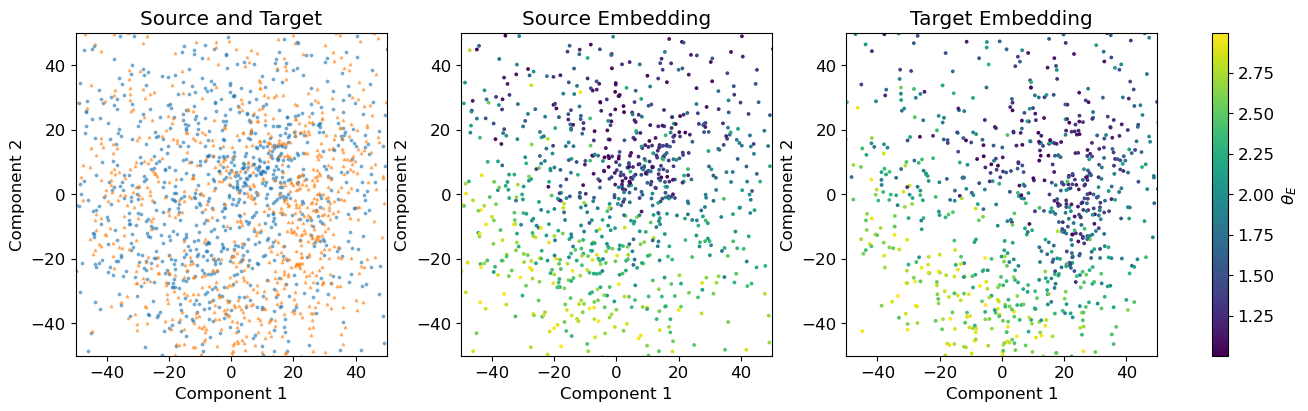


Epoch 120: 11.21s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2080
	Train Regression Loss: : 0.0226
	Train Mve Loss: : 24.5802
	Train R2 Score: : 0.9304
 Validation Statistics:
	Val Source Regression Loss: : 0.0210
	Val Target Regression Loss: : 0.0601
	Val Source R2 Score: : 0.9354
	Val Target R2 Score: : 0.8154
	Val Source Mve Loss: : 3.4510
	Val Target Mve Loss: : 85.2917

Epoch 121: 10.63s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2075
	Train Regression Loss: : 0.0218
	Train Mve Loss: : 31.4236
	Train R2 Score: : 0.9330
 Validation Statistics:
	Val Source Regression Loss: : 0.0240
	Val Target Regression Loss: : 0.0735
	Val Source R2 Score: : 0.9265
	Val Target R2 Score: : 0.7720
	Val Source Mve Loss: : 37.7269
	Val Target Mve Loss: : 77.1921

Epoch 122: 10.82s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2093
	Train Regression Loss: : 0.0252
	Train Mve Loss: : -0.6321
	Train R2 Score: : 0.92

In [8]:
print("Beginning Training...")


for curr_epoch in range(stats['epoch_no'], stats['epoch_no'] + extra_epoch):

        #Generate isomaps every 20 epochs
        if (curr_epoch % 20 == 0):
            print("Generating Isomap...")
            source_iso, target_iso = generate_isomaps(source_data, target_data, model)
            show_isomaps(source_iso, 
                         target_iso, 
                         isomap_source_label_sample, 
                         isomap_target_label_sample, 
                         save_mod_name, 
                         name = stats["epoch_no"], 
                         axlim = 50, save = True)

        # Save best models
        if (len(stats['val_target_r2_score']) > 0):
            
            # Save and overwrite model every best target R2
            if (stats['val_target_r2_score'][-1] > best_target_R2):
                print("Saving Model...", end = ' ')
                save_model(save_mod_name, model, optimizer, stats)
                best_target_R2 = stats['val_target_r2_score'][-1]
                print("Done.")
                
            # Save and overwrite model every best target MVE Loss
            if (stats['val_target_mve_loss'][-1] < best_mve_loss):
                print("Saving Model MVE...", end = ' ')
                mve_name = save_mod_name + "_mve"
                save_model(mve_name, model, optimizer, stats)
                best_mve_loss = stats['val_target_mve_loss'][-1]
                print("Done.")

        
        start_time = time.time()

        beta = beta_function(curr_epoch)
        da_weight = da_weight_function(curr_epoch)

        # Train, backpropagate
        vals = train_loop_mve(source_train_dataloader, 
                              target_train_dataloader, 
                              model,
                              regressor_loss_fn, 
                              da_loss_fn, 
                              optimizer,
                              da_weight, 
                              beta)

        # Test, validate metrics
        vals_validate = test_loop_mve(source_val_dataloader, 
                                      target_val_dataloader,
                                      model, 
                                      regressor_loss_fn, 
                                      beta)

        # Training Metrics
        stats['train_DA_loss'].append(vals[0])
        stats['train_regression_loss'].append(vals[1])
        stats['train_mve_loss'].append(vals[2])
        stats['train_r2_score'].append(vals[3])

        # Validation Metrics
        stats['val_source_regression_loss'].append(vals_validate[0])
        stats['val_target_regression_loss'].append(vals_validate[1])
        stats['val_source_r2_score'].append(vals_validate[2])
        stats['val_target_r2_score'].append(vals_validate[3])
        stats['val_source_mve_loss'].append(vals_validate[4])
        stats['val_target_mve_loss'].append(vals_validate[5])
        
        # Other Parameters
        stats['da_weight'].append(da_weight)
        stats['beta'].append(beta)
        stats['epoch_no'] += 1

        print_epoch_scores(stats, curr_epoch, time.time() - start_time)

In [9]:
# Saves the end result model after running for all stages, as well as the .json of stats

state = {
    'epoch': stats['epoch_no'],
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}
final_mod_name = save_mod_name + "_final"
torch.save(state, final_mod_name)
json.dump(stats, open(final_mod_name+'.json', 'w'))

## Visualize Results

In [10]:
# Loads a model for plotting/viz

viz_mod_name = final_mod_name # "models/start_code_test_4_final"
model.load_state_dict(torch.load(viz_mod_name)['state_dict'])
stats = json.load(open(viz_mod_name+'.json', 'r'))

In [11]:
stat_tab = pd.DataFrame(stats)
stat_tab

,train_DA_loss,train_regression_loss,train_mve_loss,train_r2_score,val_source_regression_loss,val_target_regression_loss,val_source_r2_score,val_target_r2_score,val_source_mve_loss,val_target_mve_loss,da_weight,beta,epoch_no
0,0.235979,1.951840,0.856923,-5.011643,0.815736,0.804839,-1.494867,-1.476059,0.324445,0.324277,0,1.000,125
1,0.215549,0.486065,0.117051,-0.484763,0.354092,0.379383,-0.071115,-0.161865,0.007597,0.023144,0,0.992,125
2,0.221317,0.303376,-0.026271,0.074160,0.270536,0.290824,0.174398,0.101380,-0.041242,-0.031360,0,0.984,125
3,0.228591,0.227876,-0.056134,0.303231,0.196934,0.212446,0.398022,0.345752,-0.061361,-0.053392,0,0.976,125
4,0.235525,0.156045,-0.069782,0.522166,0.126045,0.146613,0.616548,0.546640,-0.071932,-0.062770,0,0.968,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,0.207956,0.022636,24.580195,0.930359,0.021020,0.060141,0.935431,0.815418,3.451005,85.291685,0,0.040,125
121,0.207479,0.021846,31.423637,0.933021,0.024046,0.073465,0.926525,0.771988,37.726864,77.192074,0,0.032,125
122,0.209278,0.025161,-0.632110,0.922825,0.024672,0.073868,0.924518,0.767797,-0.196747,-0.608808,0,0.024,125
123,0.210876,0.024854,-0.397101,0.923385,0.024413,0.077061,0.924632,0.755071,2.703943,23.262040,0,0.016,125


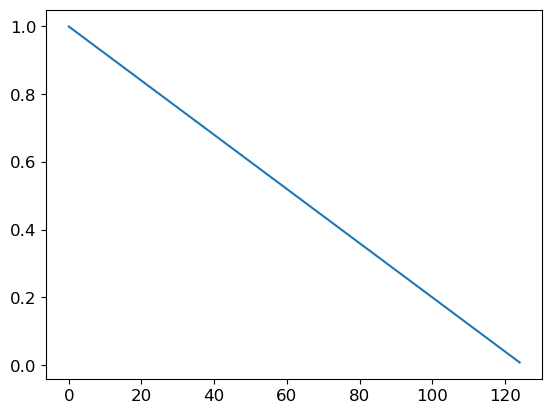

In [12]:
plt.plot(stat_tab['beta']) 

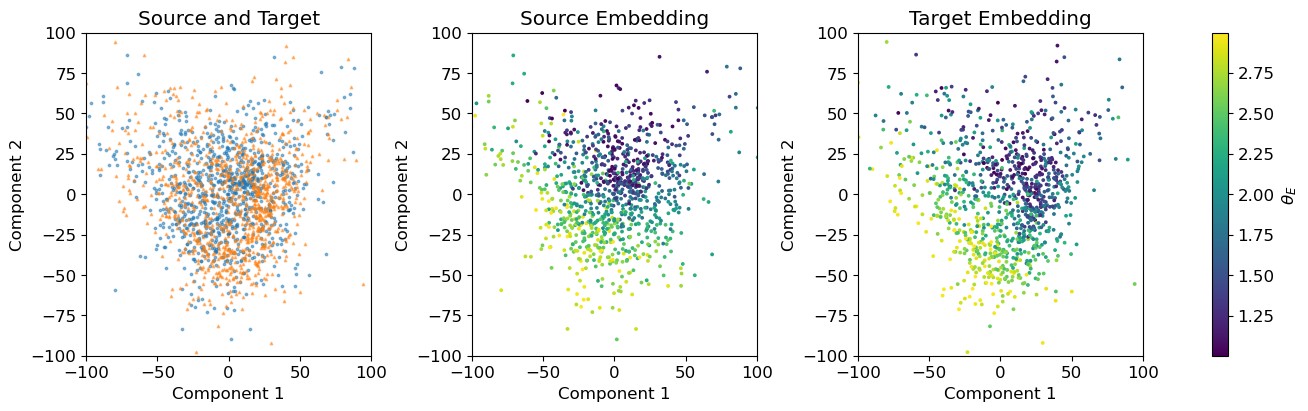

(<Figure size 1300x400 with 4 Axes>,
 array([<Axes: title={'center': 'Source and Target'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Source Embedding'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Target Embedding'}, xlabel='Component 1', ylabel='Component 2'>],
       dtype=object))

In [13]:
# Visualize isomaps 
trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data, model)
show_isomaps(trained_source_iso, trained_target_iso, isomap_source_label_sample, isomap_target_label_sample, viz_mod_name, axlim = 100)

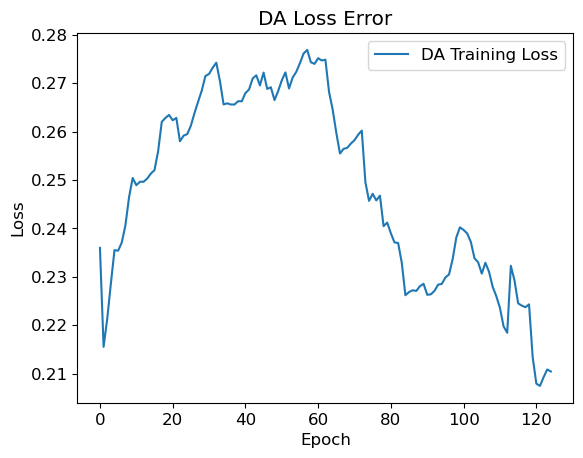

In [14]:
# DA Loss
fmt = lambda k: " ".join([i.capitalize() for i in k.split('_')])
eps = np.arange(stats["epoch_no"])
plt.title("DA Loss Error")
plt.plot(eps, stats['train_DA_loss'], label = "DA Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

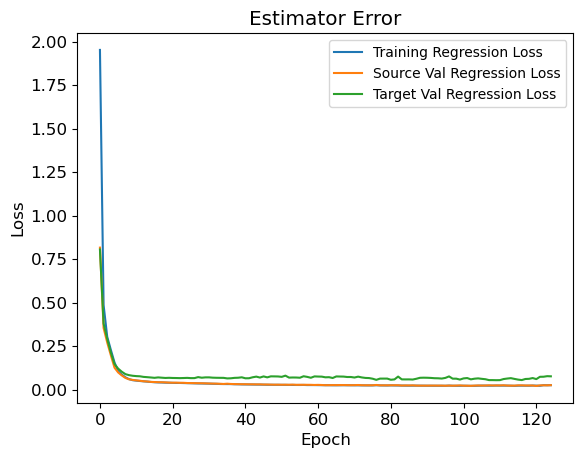

In [15]:
# Estimator / Regression
plt.title("Estimator Error")
plt.plot(eps, stats['train_regression_loss'], label = "Training Regression Loss")
plt.plot(eps, stats['val_source_regression_loss'], label = "Source Val Regression Loss")
plt.plot(eps, stats['val_target_regression_loss'], label = "Target Val Regression Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')

(-1.0, 1.0)

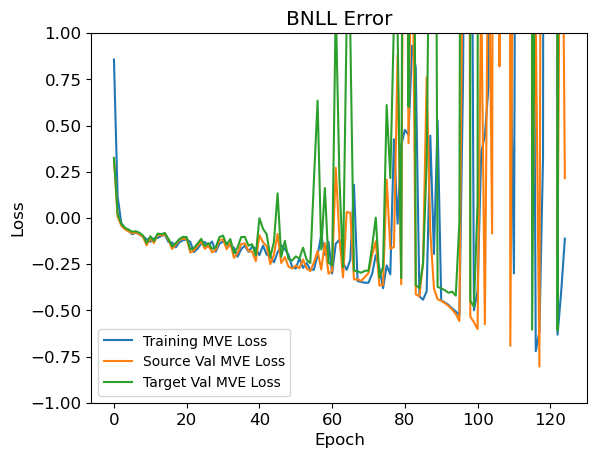

In [16]:
# BNLL for MVE
plt.title("BNLL Error")
plt.plot(eps, stats['train_mve_loss'], label = "Training MVE Loss")
plt.plot(eps, stats['val_source_mve_loss'], label = "Source Val MVE Loss")
plt.plot(eps, stats['val_target_mve_loss'], label = "Target Val MVE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')
plt.ylim(-1, 1)

(0.5, 1.0)

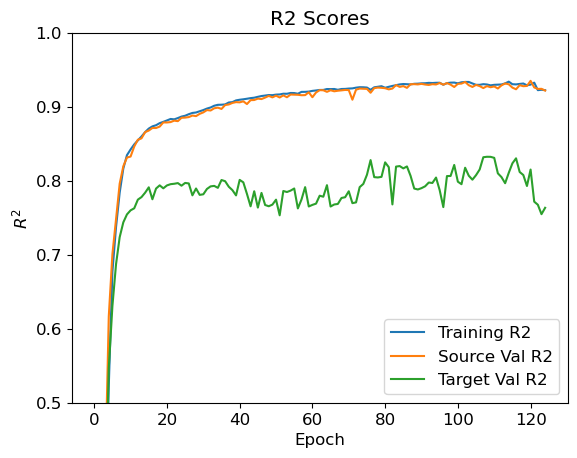

In [17]:
# R2 Scores
plt.title("R2 Scores")
plt.plot(eps, stats['train_r2_score'], label = "Training R2")
plt.plot(eps, stats['val_source_r2_score'], label = "Source Val R2")
plt.plot(eps, stats['val_target_r2_score'], label = "Target Val R2")
plt.xlabel("Epoch")
plt.ylabel("$R^2$")
plt.legend()
plt.ylim(0.5, 1)

In [18]:
# Test Source
var_preds_source = np.array([])
preds_source = np.array([])
true_source = np.array([])
lbnll_source = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in source_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_source = np.append(preds_source, pred[:, 0].cpu())
        var_preds_source = np.append(var_preds_source, pred[:, 1].cpu())
        true_source = np.append(true_source, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_source = np.append(lbnll_source, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))

score = np.mean(score_list)
print(f'Source R2 Score is {score:.4f}')

Source R2 Score is 0.9205


Text(0.5, 1.0, 'MMD | Source | R2: 0.921')

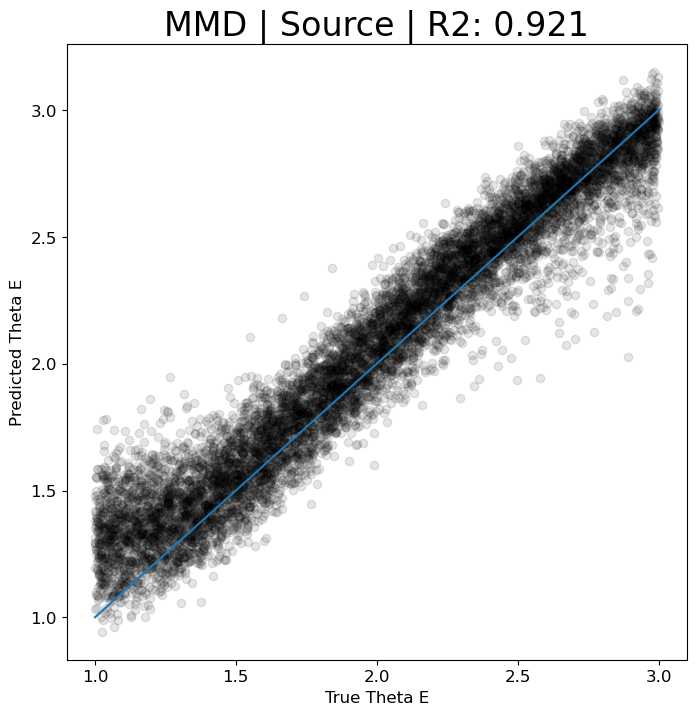

In [19]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, preds_source,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Source | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Source | BNLL: -0.330')

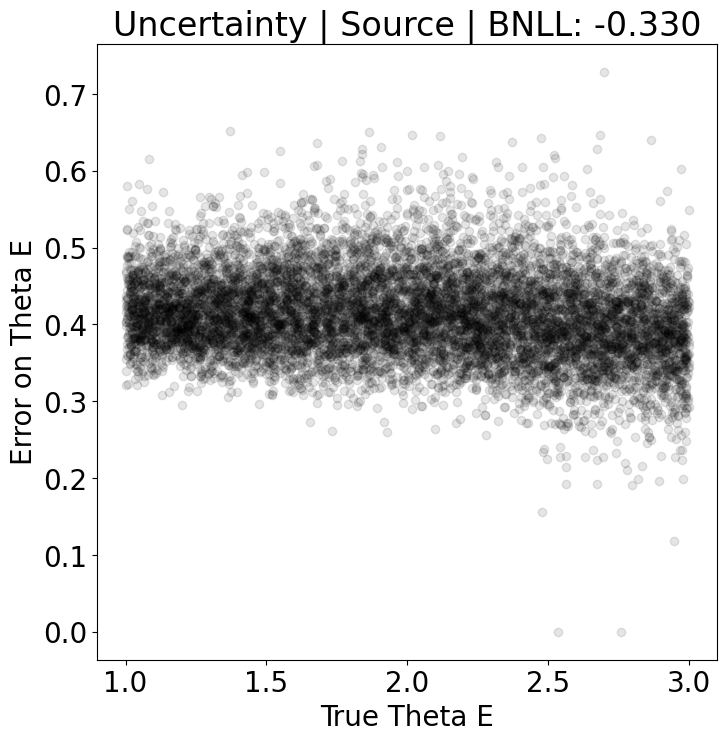

In [20]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, np.sqrt(var_preds_source),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Source | BNLL: {0:.3f}'.format(np.mean(lbnll_source)))

In [21]:
# Test target
preds_target = np.array([])
var_preds_target = np.array([])
true_target = np.array([])
score_list = np.array([])
lbnll_target = np.array([])


with torch.no_grad():
    for X, y in target_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_target = np.append(preds_target, pred[:, 0].cpu())
        var_preds_target = np.append(var_preds_target, pred[:, 1].cpu())
        true_target = np.append(true_target, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_target = np.append(lbnll_target, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))


score = np.mean(score_list)
print(f'Target R2 Score is {score:.4f}')

Target R2 Score is 0.7561


Text(0.5, 1.0, 'MMD | Target | R2: 0.756')

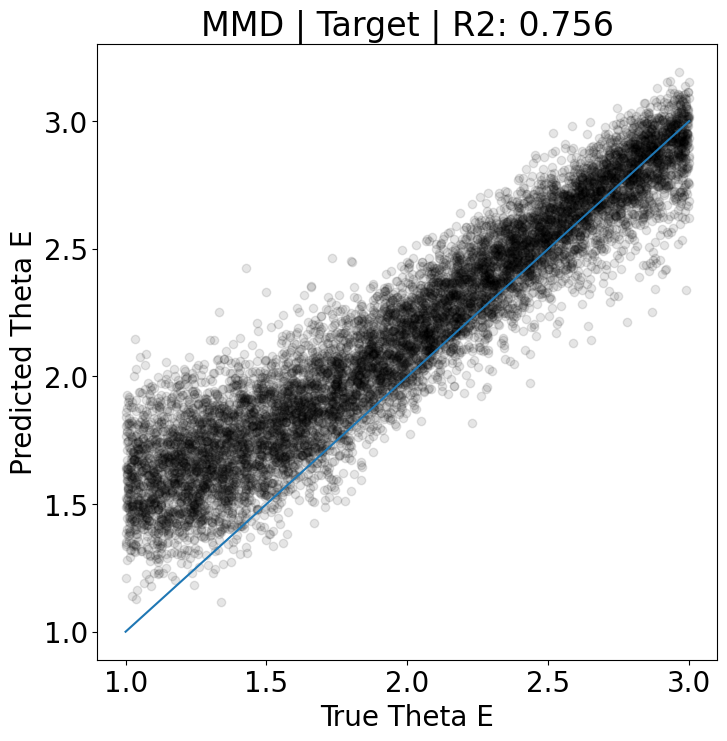

In [22]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, preds_target,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'MMD | Target | R2: 0.756')

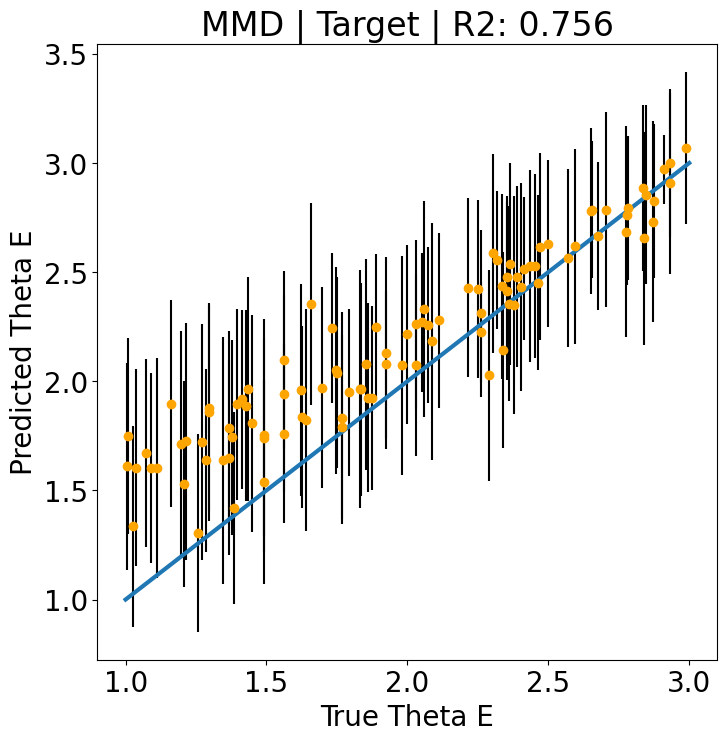

In [23]:
plt.figure(figsize=(8,8))
idx = np.random.choice(np.arange(len(true_target)), 100)
plt.errorbar(true_target[idx], preds_target[idx], yerr = np.sqrt(var_preds_target[idx]), fmt = 'o', color='orange', ecolor = 'k', alpha = 1)
line = np.linspace(1, 3, 100)
plt.plot(line, line, lw = 3)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Target | BNLL: -0.261')

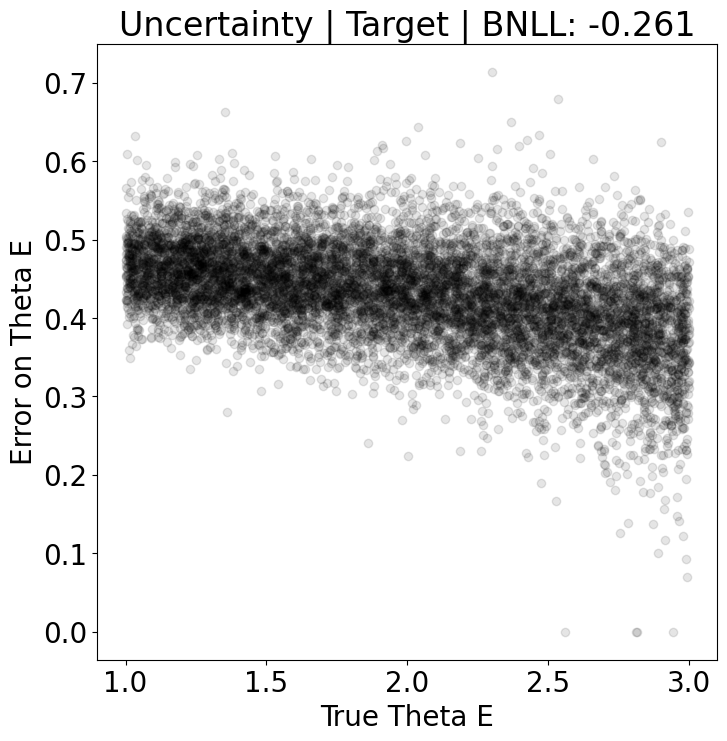

In [24]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, np.sqrt(var_preds_target),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Target | BNLL: {0:.3f}'.format(np.mean(lbnll_target)))

In [25]:
def sample_variance(obs, true):
    return np.std(obs - true) ** 2

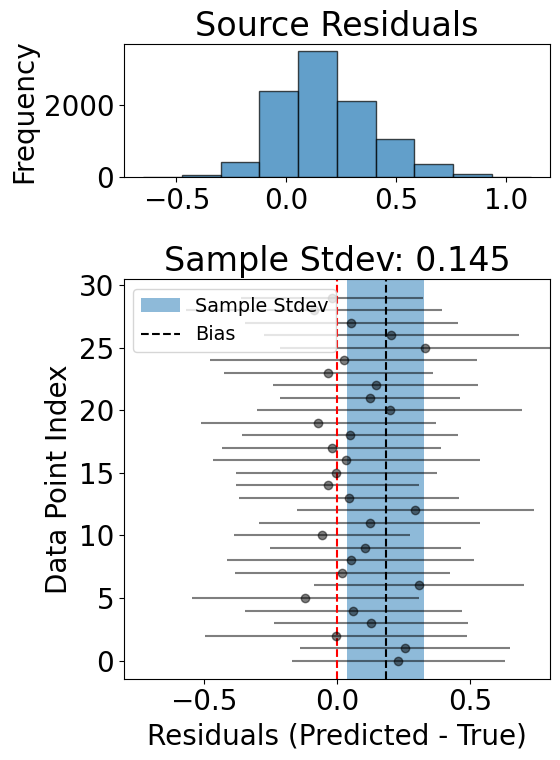

In [26]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_source[rand_idx] - true_source[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_source[rand_idx])
sv = np.sqrt(sample_variance(preds_source, true_source))
mn = np.mean(resid_all)

# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=10, edgecolor='black', alpha=0.7)
ax_hist.set_title('Source Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 'x-small')

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()

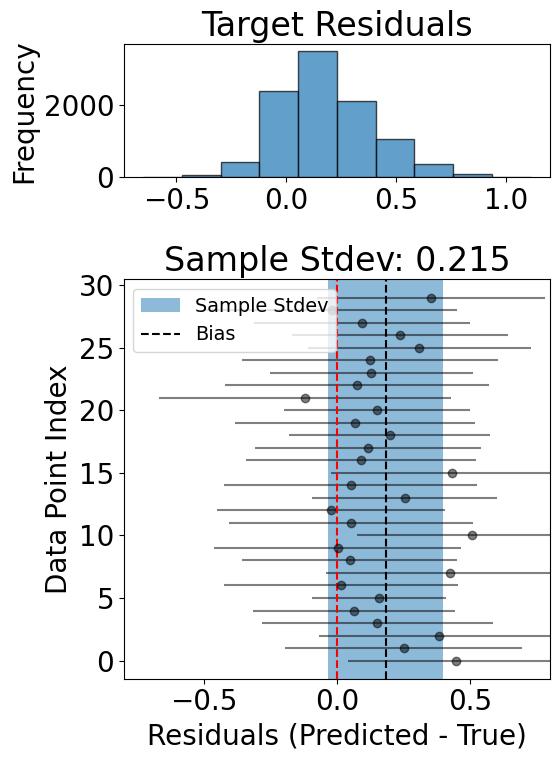

In [27]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_target[rand_idx] - true_target[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_target[rand_idx])
sv = np.sqrt(sample_variance(preds_target, true_target))
mn = np.mean(resid_all)
# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=10, edgecolor='black', alpha=0.7)
ax_hist.set_title('Target Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 'x-small')

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()